In [38]:
import librosa
import numpy as np
from pathlib import Path
import IPython.display as ipd
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [39]:
class DrumDataset(Dataset):
    def __init__(self, file_paths, transform=None, target_length=16384):
        self.file_paths = file_paths
        self.transform = transform
        self.target_length = target_length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        audio, _ = torchaudio.load(self.file_paths[idx])
        audio = audio.mean(dim=0)
        if len(audio) > self.target_length:
            audio = audio[:self.target_length]
        else:
            padding = self.target_length - len(audio)
            audio = torch.nn.functional.pad(audio, (0, padding))

        if self.transform:
            audio = self.transform(audio)

        # print(audio.shape)
        
        return audio.unsqueeze(0)


In [40]:
import torch.nn as nn
class WaveGANGenerator(nn.Module):
    def __init__(self, latent_dim=100, model_dim=64):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(latent_dim, 256*model_dim),
            nn.Unflatten(1, (16*model_dim, 16)),
            nn.ReLU(True),
            nn.ConvTranspose1d(16*model_dim, 8*model_dim, kernel_size=25, stride=4, padding=11, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(8*model_dim, 4*model_dim, kernel_size=25, stride=4, padding=11, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(4*model_dim, 2*model_dim, kernel_size=25, stride=4, padding=11, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(2*model_dim, model_dim, kernel_size=25, stride=4, padding=11, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(model_dim, 1, kernel_size=25, stride=4, padding=11, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # print("G Input shape:", x.shape)
        # for layer in self.network:
        #     x = layer(x)
        #     print(f"After {layer.__class__.__name__}:", x.shape)
        return self.network(x)

In [41]:
import torch.nn as nn

class WaveGANDiscriminator(nn.Module):
    def __init__(self, model_dim=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv1d(1, model_dim, kernel_size=25, stride=4, padding=11),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(model_dim, 2*model_dim, kernel_size=25, stride=4, padding=11),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(2*model_dim, 4*model_dim, kernel_size=25, stride=4, padding=11),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(4*model_dim, 8*model_dim, kernel_size=25, stride=4, padding=11),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(8*model_dim, 16*model_dim, kernel_size=25, stride=4, padding=11),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(start_dim=1,end_dim=-1),
            nn.Linear(256*model_dim, 1),
        )

    def forward(self, x):
        # print("D Input shape:", x.shape)
        # for layer in self.network:
        #     x = layer(x)
        #     print(f"After {layer.__class__.__name__}:", x.shape)
        return self.network(x)

In [208]:
from torch import optim


criterion = nn.BCELoss()
model_dim = 64
beta1 = 0.5

generator = WaveGANGenerator()
discriminator = WaveGANDiscriminator()

optimizerG = optim.Adam(generator.parameters(), lr=0.0001, betas=(beta1, 0.9))
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(beta1, 0.9))

In [225]:
from torch.utils.data import DataLoader

file_paths = [str(p) for p in Path().glob('../data/Snares/snarestest/*.wav')]

dataset = DrumDataset(file_paths)

batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [247]:
def gradient_penalty(critic, real_samples, fake_samples, device="cpu"):
    # Interpolate between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, device=device)
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Get critic output for the interpolated samples
    interpolated_output = critic(interpolated)

    # Compute gradients
    gradients = torch.autograd.grad(
        outputs=interpolated_output,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_output),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1) ** 2)
    return penalty

def critic_loss(real_output, fake_output):
    return torch.mean(fake_output) - torch.mean(real_output)

def generator_loss(fake_output):
    return -torch.mean(fake_output)

def plot_waveform(waveform, epoch, save=False):
    """
    Plots the generated waveform.
    
    Parameters:
    - waveform: The generated waveform tensor.
    - epoch: Current epoch number (for the title).
    - save: If True, saves the plot as an image instead of displaying it.
    """
    waveform_np = waveform.squeeze().detach().cpu().numpy()  # Convert to numpy for plotting

    plt.figure(figsize=(4, 2))
    plt.plot(np.linspace(0, 1, len(waveform_np)), waveform_np)
    plt.title(f"Generated Waveform at Epoch {epoch}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.ylim((-1,1))
    if save:
        plt.savefig(f"generated_waveform_epoch_{epoch}.png")
        plt.close()  # Close the plot if saving to avoid memory issues
    else:
        plt.show()  # Show the plot

In [ ]:
import librosa as lr

import torchaudio.transforms as T
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

spectrogram_transform = T.Spectrogram(n_fft=512)

def spectral_loss(real, generated):
    real_spectrogram = spectrogram_transform(real)
    generated_spectrogram = spectrogram_transform(generated)
    return F.mse_loss(real_spectrogram, generated_spectrogram)

num_epochs = 100
latent_dim = 100
n_critic = 5
lambda_gp = 10
num_batches = 1

for epoch in range(num_epochs):
    for idx, real_data in enumerate(dataloader):
        if idx >= num_batches:
            break

        # Move real data to device and train discriminator (critic)
        real_data = real_data.to(device)
        for _ in range(n_critic):
            noise = torch.rand(real_data.size(0), latent_dim, device=device) * 2 - 1
            fake_samples = generator(noise).detach()
            
            real_output = discriminator(real_data)
            fake_output = discriminator(fake_samples)
            
            gp = gradient_penalty(discriminator, real_data, fake_samples, device)
            d_loss = critic_loss(real_output, fake_output) + lambda_gp * gp
            
            optimizerD.zero_grad()
            d_loss.backward()
            optimizerD.step()

        # Train generator
        noise = torch.rand(real_data.size(0), latent_dim, device=device) * 2 - 1
        fake_data = generator(noise)
        g_loss = generator_loss(discriminator(fake_data)) + 0.1*spectral_loss(real_data, fake_data)

        optimizerG.zero_grad()
        g_loss.backward()
        optimizerG.step()
        with torch.no_grad():
            test_noise = torch.rand(1, latent_dim, device=device) * 2 - 1
            test_waveform = generator(test_noise)
            
            # Plot or save the generated waveform
            plot_waveform(test_waveform, epoch+1, save=False)  # Set save=True to save images instead of showing

    print(f"Epoch: {epoch+1}/{num_epochs}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")
        

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x150 and 100x16384)

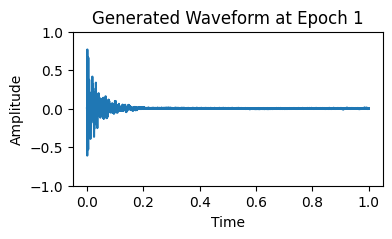

In [294]:
# Generate sample
noise = torch.rand(1, latent_dim).to(device)*2 - 1

generator.eval()

sample = generator(noise)


plot_waveform(sample, 1)

In [295]:
from IPython.display import Audio
sr = [lr.load(p)[1] for p in Path().glob('../data/Snares/*.wav')]

Audio(sample[0].detach().numpy(), rate=sr[0])

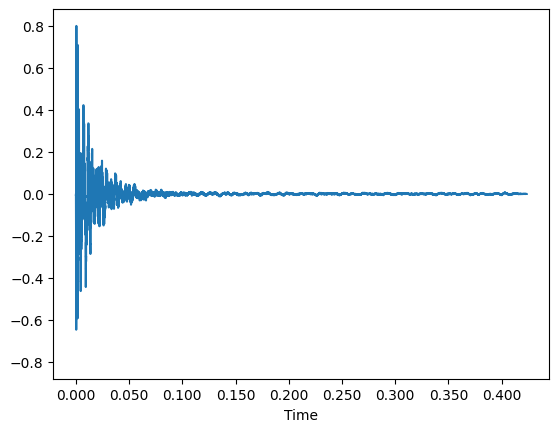

In [245]:
samples = [lr.load(p)[0] for p in Path().glob('../data/Snares/snarestest/*.wav')]

lr.display.waveshow(samples[0])

In [ ]:

num=2
Audio(data=samples[num], rate=sr[num])